In [1]:
import h5py # for working with HDF5 (Hierarchical Data Format) files
import numpy as np
import sklearn.svm
import matplotlib.pyplot as plt
import pandas as pd
import os
from V3.load_calcium_video import load_video_data
from V3.align_behavior_to_calcium import align_files_old_labels, align_files_new_labels
from V3.class_balance import check_class_imbalance_old, check_class_imbalance_new 
from V3.preprocessing_model import model_preprocessing

2023-05-10 11:41:19.355143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 11:41:19.394285: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
comment = "k-fold-cross validation, multiple videos, new labels"
experiment_ID = '3.4'
data_file = 'Animal3learnday8, Animal3Learnday9, Animal3Learnday10'
experiment_name = str(data_file)+"_"+str(experiment_ID)
train_test_split_strategy = "k-fold"
name = 'BPSVM'
model_version = str(name)+'_1'

%store experiment_ID

Stored 'experiment_ID' (str)


In [3]:
# Which labels am I using? Old or New?
labels_type = 'new' # or 'old'

In [4]:
# Define the name of the output directory
output_dir = "output-svm"

# Check if the output directory already exists
if not os.path.exists(output_dir):
    # Create the output directory
    os.mkdir(output_dir)

    # Create the balance, accuracy, loss, and cm directories inside the output directory
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
else:
    print(f"The directory {output_dir} already exists.")

The directory output-svm already exists.


### Loading Calcium Videos

In [5]:
# paths to videos
video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]

In [6]:
# load the CSV file with the FOV information
fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')

In [7]:
video_name_list = []
video_data_list = []

images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

20211025_184906_animal3learnday8.nwb recording_20211025_184906-PP-BP-MC
20211025_184906_animal3learnday8.nwb is cropped
(24479, 356, 398)
20211026_142935_animal3learnday9.nwb recording_20211026_142935-PP-BP-MC
20211026_142935_animal3learnday9.nwb is cropped
(24434, 356, 398)
20211027_165052_animal3learnday10.nwb recording_20211027_165052-PP-BP_001-MC
20211027_165052_animal3learnday10.nwb is cropped
(24456, 356, 398)
Concatenated video shape: (73369, 356, 398)


In [8]:
images[0].shape

(356, 398)

In [9]:
# Check if the video has been loaded correctly
images[:1]

array([[[175, 172, 164, ..., 157, 163, 172],
        [167, 167, 168, ..., 164, 158, 166],
        [171, 170, 167, ..., 161, 155, 160],
        ...,
        [172, 156, 151, ..., 171, 166, 167],
        [163, 162, 157, ..., 167, 163, 170],
        [146, 162, 160, ..., 161, 161, 160]]], dtype=int16)

In [10]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  73369  and the frame dimensions (height x width) are:  356 X 398


### Extract Calcium Traces

In [11]:
path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/animal3.h5"

In [12]:
# manually change from which videos you want to extract calcium traces
list_of_traces = []
with (h5py.File(path, 'r')) as f:
    traces_8 = np.array(f['traces/animal3learnday8/deconvolved'])
    list_of_traces.append(traces_8)
    traces_9 = np.array(f['traces/animal3learnday9/deconvolved'])
    list_of_traces.append(traces_9)
    traces_10 = np.array(f['traces/animal3learnday10/deconvolved'])
    list_of_traces.append(traces_10)

In [13]:
traces = np.concatenate(list_of_traces, axis=1)
print("Concatenated traces shape:", traces.shape)

Concatenated traces shape: (110, 73369)


### Load Labels

In [14]:
num_of_videos = 3

In [15]:
bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]

if labels_type == 'old':
    
    
    behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

    df_new_annotations = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)
    
    
else:
    h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
    df_new_annotations = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)

In [16]:
# behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

In [17]:
# df_new_annotations = align_files(bonsai_paths, behavior_paths, num_of_videos)
# df_new_annotations = align_files(bonsai_paths, num_of_videos, h5_path)

In [18]:
# df_new_annotations = df_new_annotations.loc[:, 'state_id']    

In [19]:
df_new_annotations = df_new_annotations.reset_index(drop=True)
# df_new_annotations = df_new_annotations.reset_index()

In [20]:
df_new_annotations_unique = df_new_annotations.unique()

In [21]:
df_new_annotations_unique

array([0, 1, 2, 3, 4, 5], dtype=object)

In [22]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/output-svm/balance"

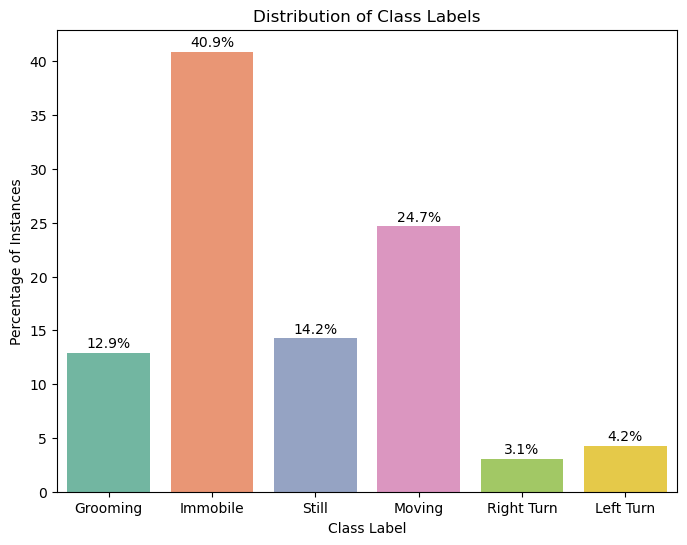

In [23]:
if labels_type == 'old':
    class_counts, total_counts = check_class_imbalance_old(df_new_annotations, experiment_ID, save_dir)
else:
    class_counts, total_counts = check_class_imbalance_new(df_new_annotations, experiment_ID, save_dir)

In [24]:
labels = df_new_annotations.values

In [25]:
labels

array([0, 0, 1, ..., 1, 1, 1], dtype=object)

In [26]:
labels.shape

(24456,)

In [27]:
type(labels)

numpy.ndarray

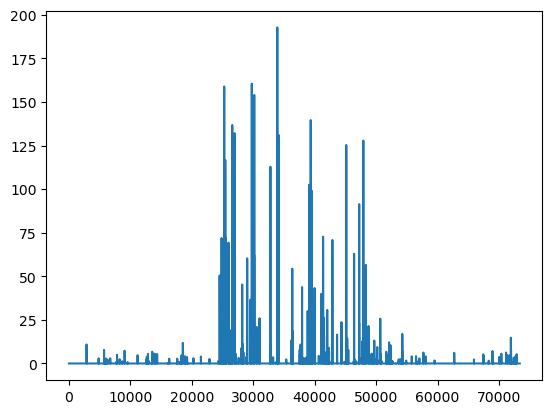

In [28]:
# data verification
plt.plot(traces[50])

In [29]:
type(traces[50])

numpy.ndarray

In [30]:
traces.shape

(110, 73369)

In [31]:
num_classes = len(df_new_annotations_unique)

In [32]:
num_classes

6

In [33]:
# traces, labels, num_classes = model_preprocessing(traces, labels, df_new_annotations_unique)

In [34]:
# labels

In [35]:
labels = labels.astype(np.int32)

## Perform k-fold cross validation

In [36]:
mySVC = sklearn.svm.LinearSVC()

In [37]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.svm import LinearSVC


mySVC.fit(traces.T, labels)
mySVC.predict(traces.T)

mySVC = LinearSVC()

kf = KFold(n_splits=5)

y_pred = cross_val_predict(mySVC, traces.T, labels, cv=kf)

accuracy = accuracy_score(labels, y_pred)
print("Average accuracy:", accuracy)

y_pred_prob = cross_val_predict(mySVC, traces.T, labels, cv=kf, method='decision_function')
log_loss_avg = log_loss(labels, y_pred_prob)
print("Average log loss:", log_loss_avg)

cm_avg = confusion_matrix(labels, y_pred)
print("Confusion matrix:")
print(cm_avg)

ValueError: Found input variables with inconsistent numbers of samples: [73369, 24456]

In [ ]:
# Shuffle the labels
shuffled_labels = np.random.permutation(labels)

# Use the shuffled labels for cross-validation
y_pred = cross_val_predict(mySVC, traces.T, shuffled_labels, cv=kf)

# Calculate accuracy using shuffled labels
accuracy = accuracy_score(shuffled_labels, y_pred)
print("Shuffled accuracy:", accuracy)